In [1]:
from vae import cvae_full, dataset_full
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [2]:
# load data

full_path = './GRU_data/combined_dataset.parquet' # use cvae_full and dataset_full instead

train_dataset = dataset_full.VAEDataset(full_path)

from torch.utils.data import DataLoader
batch_size = 256
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)

### CVAE

In [3]:
# define parameters

latent_size = 256 # zmienilem na 256 zeby sie zgadzal z imputem do GRU
input_size = 4860
learning_rate = 0.0001

# init model

model = cvae_full.CVAE(input_size=input_size, latent_size=latent_size).to(device)

In [4]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

def train_CVAE(model, train_dataloader, learning_rate, epochs=100, device=device, plot_loss=False):
    
    criterion = cvae_full.VAELoss()
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    sheduler = ReduceLROnPlateau(optimizer, 'min', patience=20, verbose=True)
    losses = []
    
    if plot_loss:
        fig, ax = plt.subplots()
        dh = display(fig, display_id=True)

    for epoch in tqdm(range(1, epochs+1)):
        if epoch%10 == 0:
            torch.save(model.state_dict(), f'./models/CVAE_full_epoch_{epoch}.pt')
        for fp in train_dataloader:
            fp = fp.to(device)
            encoded, mu, logvar = model(fp)
            loss = criterion(encoded, fp, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        sheduler.step(loss)
        losses.append(loss.item())
        if plot_loss:
            ax.clear()
            ax.plot(losses)
            ax.set_title(f'Epoch {epoch}, Loss: {loss.item():.2f}')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.set_yscale('log')
            dh.update(fig)
            
    return model, losses

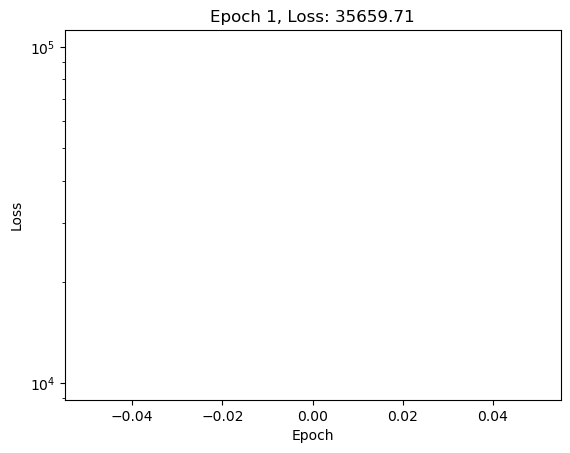

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

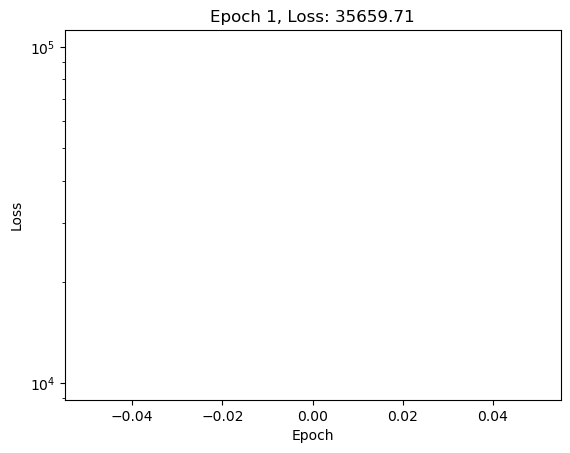

In [5]:
cvae, losses = train_CVAE(model, train_dataloader, learning_rate, 
                          epochs=100, device=device, plot_loss=True)

In [93]:
torch.save(model.state_dict(), './models/CVAE_full_.pt')

In [12]:
# encode all data into latent space

encoded_cvae = []
for (fp, y) in train_dataloader:
    fp = fp.to(device)
    y = y.to(device)
    mu, logvar = cvae.encoder(fp, y)
    enc = cvae.reparameterize(mu, logvar)
    encoded_cvae.append(enc.detach().cpu().numpy())